In [1]:
# !pip install -Uqq duckduckgo_search

In [2]:
from pathlib import Path
from time import sleep

from duckduckgo_search import ddg_images
from fastcore.all import *

In [3]:
def search_images(term, max_images=200):
    return L(ddg_images(term, max_results=max_images)).itemgot("image")

In [4]:
urls = search_images("baseball bat", max_images=1)
urls[0]

'https://i5.walmartimages.com/asr/db58db17-4ccd-4c13-b46f-3c9fb3e062e0_1.37902d6185c021734c35acfe653cc7d9.jpeg'

## Instead of bird and forest, it is cricket bat vs baseball bat vs tennis racket

In [5]:
from fastdownload import download_url
dest = "./resources/baseball_bat.jpg"
download_url(urls[0], dest)

Path('resources/baseball_bat.jpg')

/home/tharun/.conda/envs/fastai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tharun/.conda/envs/fastai/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


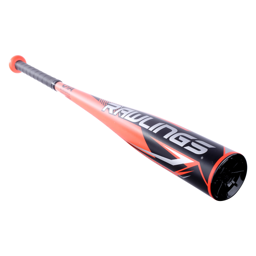

In [6]:
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

In [8]:
urls = search_images("cricket bat", max_images=1)
urls[0]

'https://res-5.cloudinary.com/s247/image/upload/c_pad,dpr_1.0,f_auto,q_auto/media/catalog/product/w/o/woodworm-cricket-ib-select-grade-1-cricket-bat.png'

In [9]:
dest = "./resources/cricket_bat.jpg"
download_url(urls[0], dest)

Path('resources/cricket_bat.jpg')

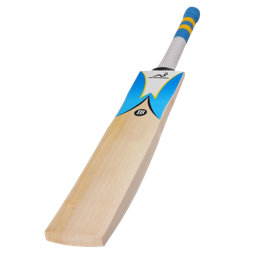

In [10]:
Image.open(dest).to_thumb(256, 256)

In [11]:
# downloading multiple images of each of the category

In [12]:
categories = ["cricket bat", "baseball bat", "tennis racket"]
path = Path("./resources/which_bat")

In [13]:
for cat in categories:
    dest = path/cat
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f"{cat} photo"))
    sleep(10)
    download_images(dest, urls=search_images(f"playing with {cat} photo"))
    sleep(10)
    download_images(dest, urls=search_images(f"posing with {cat} photo"))

In [14]:
# added max_workers argument in below code, as the earlier was raising exception broken process pool 

In [15]:
for cat in categories:
    resize_images(path/cat, max_size=400, dest=path/cat)

/home/tharun/.conda/envs/fastai/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/tharun/.conda/envs/fastai/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/tharun/.conda/envs/fastai/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Training the model

In [16]:
# !pip install nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 668.6 kB/s eta 0:00:001m130.3 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 8.5 MB/s eta 0:00:00


In [17]:
file_paths = get_image_files(path)
failed = verify_images(file_paths)
failed.map(Path.unlink)
len(failed)

15

In [21]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=13),
    get_y=parent_label,
    item_tfms=[Resize(192, method="squish")]
).dataloaders(path)

dls

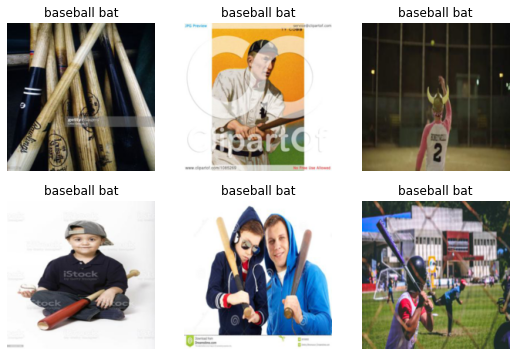

In [24]:
dls.show_batch(max_n=6)

In [28]:
learner = vision_learner(dls, resnet18, metrics=error_rate)
learner.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.217534,0.560895,0.186589,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.529975,0.496470,0.154519,00:19
1,0.349951,0.544662,0.151604,00:19
2,0.230084,0.494416,0.139942,00:19


## Model usage

In [83]:
def get_random_image():
    resource_path = Path("./resources/")
    return random.choice([x for x in resource_path.glob("**/*") if x.is_file()])

get_random_image()

Path('resources/which_bat/cricket bat/387d0bbe-0dcc-4ca7-b2c7-2e1792c4b9df.jpg')

Prediction: tennis racket
Probability that it is a tennis racket is 1.0000


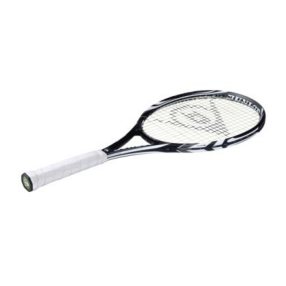

In [137]:
random_image = get_random_image()
is_which_bat, _, probs = learner.predict(PILImage.create(random_image))
show_image(Image.open(random_image))
print(f"Prediction: {is_which_bat}")

match is_which_bat:
    case "cricket bat":
        prob = probs[1]
    case "baseball bat":
        prob = probs[0]
    case "tennis racket":
        prob = probs[2]

print(f"Probability that it is a {is_which_bat} is {prob:.4f}")